In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

In [1]:
import pandas as pd
import os
os.chdir(os.path.dirname(os.getcwd()))
import numpy as np
from datetime import datetime,date
from dateutil import relativedelta
import matplotlib.pyplot as plt
import copy
%load_ext autoreload
%autoreload 2
from src.data import preprocessing
from src.analysis import forecasting
import pickle as pkl
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm

In [2]:
DATA_PATH = './data/raw/'
os.listdir(DATA_PATH)

raw_data = pd.read_excel(DATA_PATH + os.listdir(DATA_PATH)[1])

gas_prices = preprocessing.prepare_data(raw_data)

Trying to load data from cache...
Loaded data from cache.
Here are the names of the worksheets:
Notes Grunddata GPN WD TTF Gaspool NCG Weather forecast Weather observations


In [3]:
gas_prices['Notes']

,Sheet,Description,Unnamed: 2,Markets,Unnamed: 4
0,Grunddata:,Prices for DayAhead and Weekends on all 4 rele...,NaN,GPL,Gaspool (Germany)
1,NaN,Includes Monthly Index,NaN,NCG,NetConnectGermany
2,GPN WD,Within Day prices DK,NaN,TTF,TitleTransferFacility (Holland)
3,"TTF, Gaspool, NCG",Prices for future contracts,NaN,GPN,GasPointNodic (Denmark)
4,Weather forecast,Self explanatory,NaN,NaN,NaN
5,Weather observations,Self explanatory,NaN,DMIFilesID,Area
6,NaN,NaN,NaN,1,KBH
7,NaN,NaN,NaN,2,MJYL
8,NaN,NaN,NaN,3,NJYL
9,NaN,NaN,NaN,4,FYN


In [4]:
## Preprocessing of 'Grunddata'

period = 'Day-ahead'
market = 'GPN'

gas_Grunddata = gas_prices['Grunddata']#[gas_prices['Grunddata']['Periode'] == period]
market_data_GPN = gas_Grunddata.loc[:,market]
market_data_GPN.index = gas_Grunddata.loc[:,'Delivery date']
market_data_GPN.index = pd.DatetimeIndex(market_data_GPN.index.values, freq=market_data_GPN.index.inferred_freq)

## Preprocessing of 'GPN WD'

market_data_GPN_WD = gas_prices['GPN WD'].loc[:,'WD']
market_data_GPN_WD.index = gas_prices['GPN WD'].loc[:,'Date']
market_data_GPN_WD.index = pd.DatetimeIndex(market_data_GPN_WD.index.values, freq=market_data_GPN_WD.index.inferred_freq)

In [20]:
gas_Grunddata.columns

Index(['Month', 'Quote date', 'Delivery date', 'Periode', 'Dag', 'TTF Bid',
       'TTF offer', 'TTF Mid', 'TTF Heren day-ahead+Spot weekend Index',
       'TTF Heren Monthly Index', 'TTF eex', 'NCG Heren Bid',
       'NCG Heren offer', 'NCG Heren Mid',
       'NCG Heren day-ahead + spot weekend Index', 'NCG Heren Monthly Index',
       'NCG eex', 'Gaspool Bid', 'Gaspool Offer', 'Gaspool Mid',
       'Gaspool Heren day-ahead + spot weekend Index', 'GPN',
       'GPN month-ahead'],
      dtype='object')

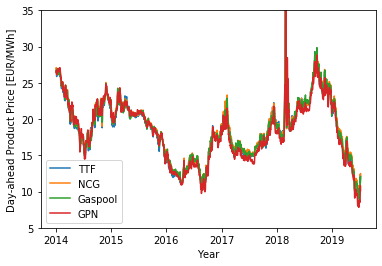

In [29]:
plotting_EEX = gas_Grunddata[['TTF Mid', 'NCG Heren Mid', 'Gaspool Mid', 'GPN']]
plotting_EEX.index = gas_Grunddata['Delivery date']
plt.plot(plotting_EEX.loc['2014':'2019'])
plt.ylim((5,35))
plt.xlabel('Year')
plt.ylabel('Day-ahead Product Price [EUR/MWh]')
plt.legend(['TTF', 'NCG', 'Gaspool', 'GPN'])

In [5]:
# Importing the file with the demand data
path_demand = '\\data\\raw\\ExitZoneAllocation.xlsx'
raw_demand = os.getcwd() + path_demand

gas_demand = pd.read_excel(raw_demand)

gas_demand = gas_demand.groupby(['Time'])['Data'].sum()


### Preprocessing the demand 
gas_demand.index = pd.to_datetime(gas_demand.index, format='%d-%m-%Y')
gas_demand.index = pd.DatetimeIndex(gas_demand.index.values, freq=gas_demand.index.inferred_freq)
gas_demand = gas_demand.sort_index()

# Changing unit to MWh and adjusting the values to demand of the company
gas_demand = gas_demand/1000 * 0.2

In [6]:
gas_demand

2012-01-01     722.6164
2012-01-02     957.4984
2012-01-03    1018.2274
2012-01-04    1046.0284
2012-01-05    1080.7904
                ...    
2019-11-27     822.9280
2019-11-28     811.5806
2019-11-29     936.1052
2019-11-30     931.0650
2019-12-01     954.3276
Name: Data, Length: 2892, dtype: float64

In [7]:
# Analysis of correlation between gas_demand and GPN prices 
final_results = pd.DataFrame(index = gas_Grunddata.loc[:,'Delivery date'], columns = ['Demand', 'GPN', 'GPN WD'])
final_results

,Demand,GPN,GPN WD
Delivery date,,,
2012-01-01,NaN,NaN,NaN
2012-01-02,NaN,NaN,NaN
2012-01-03,NaN,NaN,NaN
2012-01-04,NaN,NaN,NaN
2012-01-05,NaN,NaN,NaN
...,...,...,...
2019-07-07,NaN,NaN,NaN
2019-07-08,NaN,NaN,NaN
2019-07-09,NaN,NaN,NaN


In [8]:
final_results['Demand'] = gas_demand.loc[gas_Grunddata.loc[:,'Delivery date']]
final_results['GPN'] = market_data_GPN.loc[gas_Grunddata.loc[:,'Delivery date']]
final_results['GPN WD'] = market_data_GPN_WD.loc[gas_Grunddata.loc[:,'Delivery date']]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
final_results.Demand.loc['2013']

Delivery date
2013-01-01    764.9768
2013-01-02    956.1862
2013-01-03    918.5954
2013-01-04    858.4874
2013-01-05    788.7582
                ...   
2013-12-27    777.4298
2013-12-28    697.3208
2013-12-29    710.3402
2013-12-30    806.2352
2013-12-31    751.5990
Name: Demand, Length: 365, dtype: float64

In [10]:
#final_results_noNA = final_results[final_results.isna().sum(axis = 1) == 0]

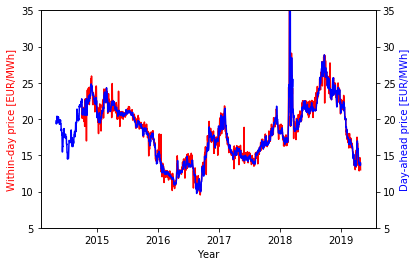

In [31]:
for i in range(2014,2015):
    fig, ax = plt.subplots()
    plt.plot(final_results['GPN WD'].loc[str(i)+'-05-01':str(i+5)+'-04-30'], color = 'red')
    ax.set_ylabel('Within-day price [EUR/MWh]', color='red')
    ax.set_xlabel('Year')
    ax.axis(ymin=5,ymax=35)
    ax2 = ax.twinx()
    plt.plot(final_results['GPN'].loc[str(i)+'-05-01':str(i+5)+'-04-30'], color='blue')
    ax2.set_ylabel('Day-ahead price [EUR/MWh]', color='blue')
    ax2.axis(ymin=5,ymax=35)
    plt.show()

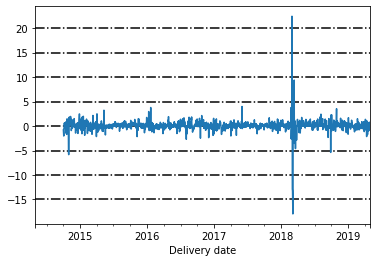

In [12]:
a = (final_results['GPN WD'] - final_results['GPN']).loc[str(i)+'-05-01':str(i+5)+'-04-30']
a.plot()
plt.hlines(y = np.arange(-15,20+1,5), xmin = a.index[0], xmax = a.index[a.shape[0] - 1], linestyles = 'dashdot')

(-5, 5)

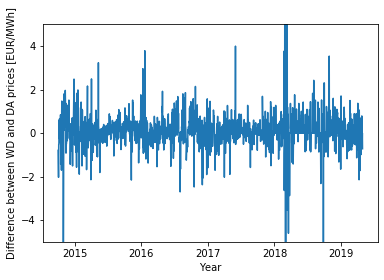

In [13]:
plt.plot((final_results['GPN WD'] - final_results['GPN']).loc[str(i)+'-05-01':str(i+5)+'-04-30'])
plt.ylabel('Difference between WD and DA prices [EUR/MWh]')
plt.xlabel('Year')
plt.ylim((-5,5))

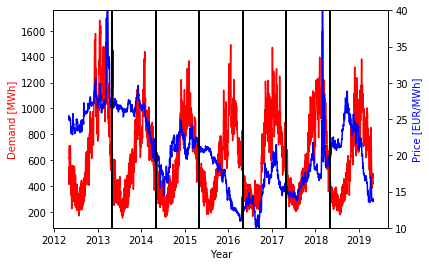

In [29]:
fig, ax = plt.subplots()
plt.plot(final_results['Demand'].loc['2012-05-01':'2019-04-30'], color = 'red')
plt.xlabel('Year')
ax.set_ylabel('Demand [MWh]', color='red')
ax2 = ax.twinx()
plt.plot(final_results['GPN'].loc['2012-05-01':'2019-04-30'], color='blue')
plt.ylim((10,40))
plt.axvline(linewidth=2, color='black',x='2013-05-01')
plt.axvline(linewidth=2, color='black',x='2014-05-01')
plt.axvline(linewidth=2, color='black',x='2015-05-01')
plt.axvline(linewidth=2, color='black',x='2016-05-01')
plt.axvline(linewidth=2, color='black',x='2017-05-01')
plt.axvline(linewidth=2, color='black',x='2018-05-01')
ax2.set_ylabel('Price [EUR/MWh]', color='blue')
plt.show()

In [166]:
final_results['GPN'].loc['2016-05-01':'2017-04-30'].reset_index()['GPN']

0      12.619
1      12.628
2      12.602
3      11.922
4      12.129
        ...  
360    15.658
361    15.602
362    15.630
363    15.608
364    15.608
Name: GPN, Length: 365, dtype: float64

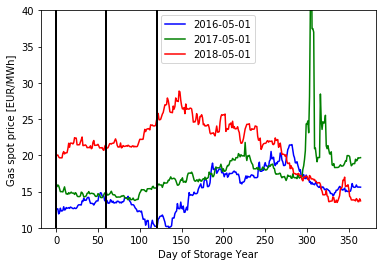

In [173]:
plt.plot(final_results['GPN'].loc['2016-05-01':'2017-04-30'].reset_index()['GPN'], color='blue')
plt.plot(final_results['GPN'].loc['2017-05-01':'2018-04-30'].reset_index()['GPN'], color='green')
plt.plot(final_results['GPN'].loc['2018-05-01':'2019-04-30'].reset_index()['GPN'], color='red')
plt.ylim((10,40))
plt.ylabel('Gas spot price [EUR/MWh]')
plt.xlabel('Day of Storage Year')
plt.legend(['2016-05-01', '2017-05-01', '2018-05-01'])
plt.axvline(linewidth=2, color='black',x=0)
plt.axvline(linewidth=2, color='black',x=60)
plt.axvline(linewidth=2, color='black',x=120)

In [188]:
final_results['GPN'].loc['2018-05-01':'2019-04-30'].groupby(pd.Grouper(freq='M')).mean()

Delivery date
2018-05-31    20.952710
2018-06-30    21.276533
2018-07-31    21.396710
2018-08-31    23.039645
2018-09-30    26.676733
2018-10-31    25.255419
2018-11-30    23.975100
2018-12-31    23.279968
2019-01-31    21.361806
2019-02-28    17.549071
2019-03-31    15.176323
2019-04-30    14.632267
Freq: M, Name: GPN, dtype: float64

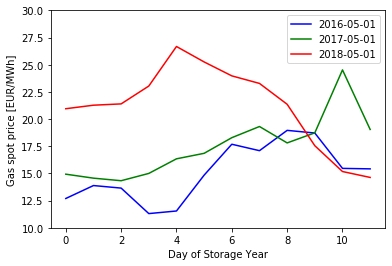

In [183]:
plt.plot(final_results['GPN'].loc['2016-05-01':'2017-04-30'].groupby(pd.Grouper(freq='M')).mean().reset_index()['GPN'], color='blue')
plt.plot(final_results['GPN'].loc['2017-05-01':'2018-04-30'].groupby(pd.Grouper(freq='M')).mean().reset_index()['GPN'], color='green')
plt.plot(final_results['GPN'].loc['2018-05-01':'2019-04-30'].groupby(pd.Grouper(freq='M')).mean().reset_index()['GPN'], color='red')
plt.ylim((10,30))
plt.ylabel('Gas spot price [EUR/MWh]')
plt.xlabel('Day of Storage Year')
plt.legend(['2016-05-01', '2017-05-01', '2018-05-01'])


In [38]:
import seaborn as sns

In [142]:
boxplot_demand_index = \
0 * (gas_demand.index < pd.to_datetime('2012-05-01')) + \
2012 * ((gas_demand.index < pd.to_datetime('2013-05-01')) & (gas_demand.index >= pd.to_datetime('2012-05-01'))) + \
2013 * ((gas_demand.index < pd.to_datetime('2014-05-01')) & (gas_demand.index >= pd.to_datetime('2013-05-01'))) + \
2014 * ((gas_demand.index < pd.to_datetime('2015-05-01')) & (gas_demand.index >= pd.to_datetime('2014-05-01'))) + \
2015 * ((gas_demand.index < pd.to_datetime('2016-05-01')) & (gas_demand.index >= pd.to_datetime('2015-05-01'))) + \
2016 * ((gas_demand.index < pd.to_datetime('2017-05-01')) & (gas_demand.index >= pd.to_datetime('2016-05-01'))) + \
2017 * ((gas_demand.index < pd.to_datetime('2018-05-01')) & (gas_demand.index >= pd.to_datetime('2017-05-01'))) + \
2018 * ((gas_demand.index < pd.to_datetime('2019-05-01')) & (gas_demand.index >= pd.to_datetime('2018-05-01'))) + \
0 * ((gas_demand.index < pd.to_datetime('2020-05-01')) & (gas_demand.index >= pd.to_datetime('2019-05-01')))

In [143]:
boxplot_demand_index = boxplot_demand_index[boxplot_demand_index != 0]

Text(0.5, 0, 'Storage Year')

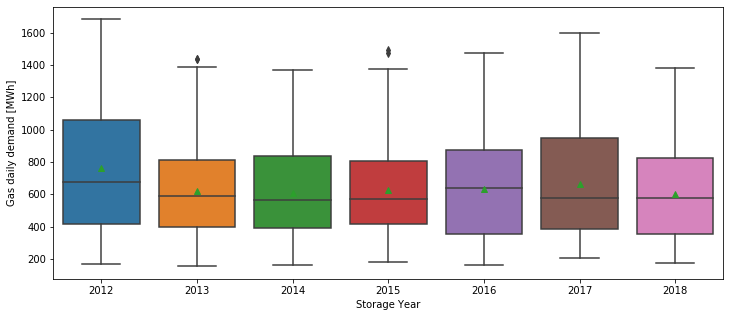

In [159]:
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(boxplot_demand_index, gas_demand.loc['2012-05-01':'2019-04-30'], ax=ax,showmeans=True)
plt.ylabel('Gas daily demand [MWh]')
plt.xlabel('Storage Year')


In [145]:
boxplot_price_index = \
0 * (market_data_GPN.index < pd.to_datetime('2012-05-01')) + \
2012 * ((market_data_GPN.index < pd.to_datetime('2013-05-01')) & (market_data_GPN.index >= pd.to_datetime('2012-05-01'))) + \
2013 * ((market_data_GPN.index < pd.to_datetime('2014-05-01')) & (market_data_GPN.index >= pd.to_datetime('2013-05-01'))) + \
2014 * ((market_data_GPN.index < pd.to_datetime('2015-05-01')) & (market_data_GPN.index >= pd.to_datetime('2014-05-01'))) + \
2015 * ((market_data_GPN.index < pd.to_datetime('2016-05-01')) & (market_data_GPN.index >= pd.to_datetime('2015-05-01'))) + \
2016 * ((market_data_GPN.index < pd.to_datetime('2017-05-01')) & (market_data_GPN.index >= pd.to_datetime('2016-05-01'))) + \
2017 * ((market_data_GPN.index < pd.to_datetime('2018-05-01')) & (market_data_GPN.index >= pd.to_datetime('2017-05-01'))) + \
2018 * ((market_data_GPN.index < pd.to_datetime('2019-05-01')) & (market_data_GPN.index >= pd.to_datetime('2018-05-01'))) + \
0 * ((market_data_GPN.index < pd.to_datetime('2020-05-01')) & (market_data_GPN.index >= pd.to_datetime('2019-05-01')))

In [146]:
boxplot_price_index = boxplot_price_index[boxplot_price_index != 0]

(5, 40)

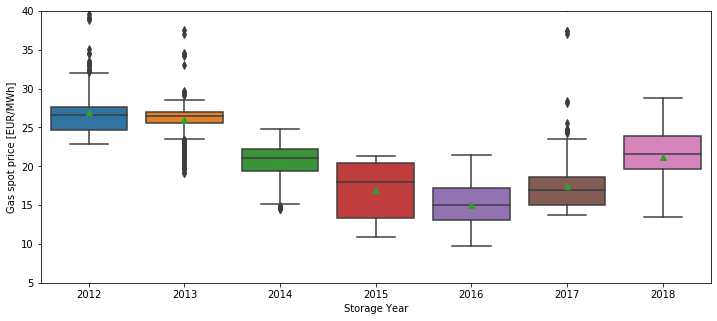

In [158]:
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(boxplot_price_index, market_data_GPN.loc['2012-05-01':'2019-04-30'], ax=ax,showmeans=True)
plt.ylabel('Gas spot price [EUR/MWh]')
plt.xlabel('Storage Year')
plt.ylim((5,40))

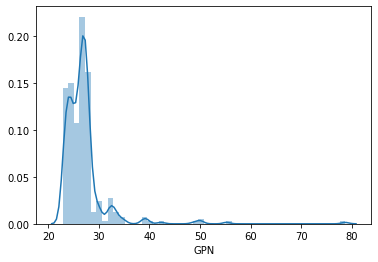

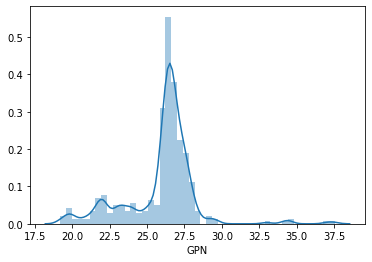

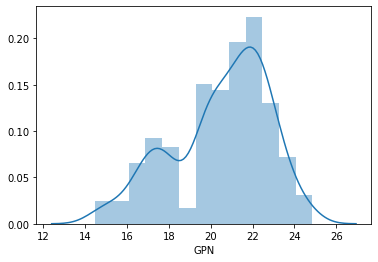

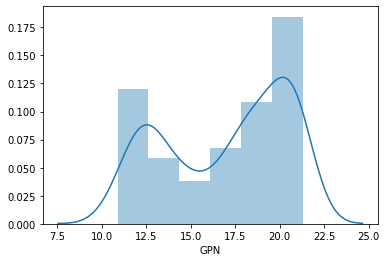

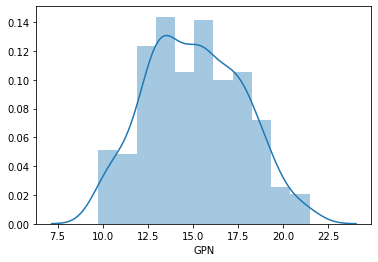

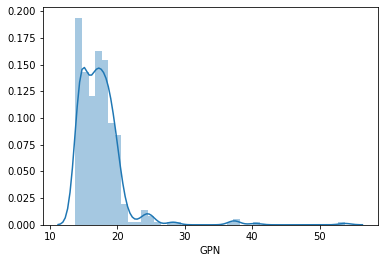

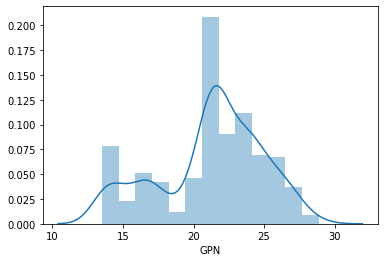

In [153]:
for i in range(2012,2019):
    sns.distplot(market_data_GPN.loc[str(i) + '-05-01':str(i+1) + '-04-30'])
    plt.show()


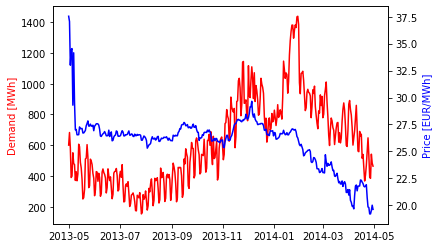

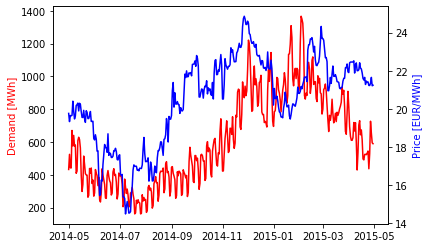

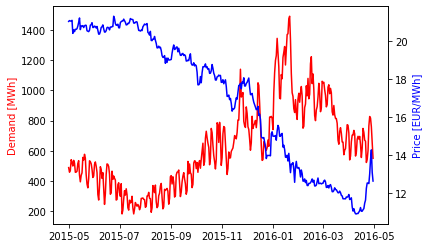

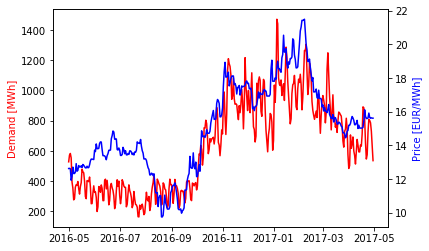

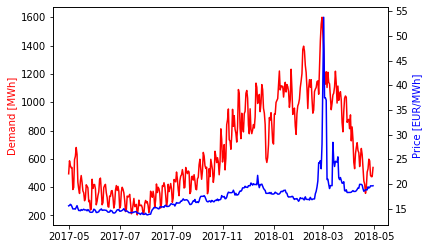

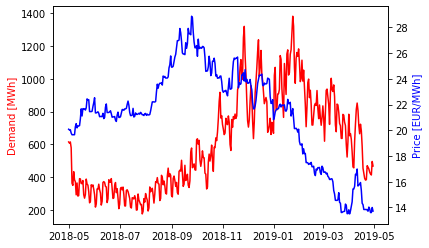

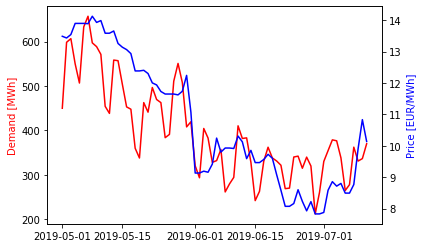

In [14]:
for i in range(2013,2020):
    fig, ax = plt.subplots()
    plt.plot(final_results['Demand'].loc[str(i)+'-05-01':str(i+1)+'-04-30'], color = 'red')
    ax.set_ylabel('Demand [MWh]', color='red')
    ax2 = ax.twinx()
    plt.plot(final_results['GPN'].loc[str(i)+'-05-01':str(i+1)+'-04-30'], color='blue')
    ax2.set_ylabel('Price [EUR/MWh]', color='blue')
    plt.show()

-0.04884673486286129


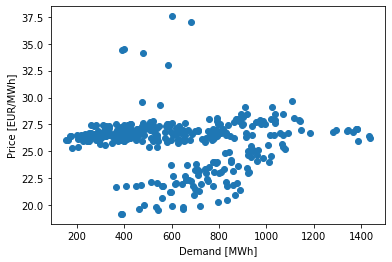

0.6718083407117134


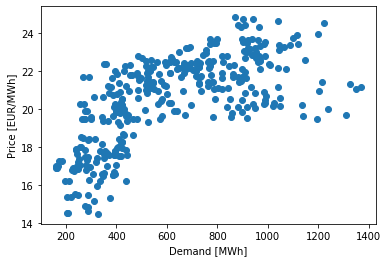

-0.7083184923810676


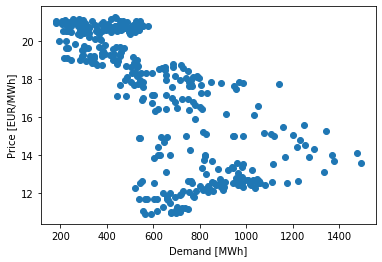

0.8572736477164782


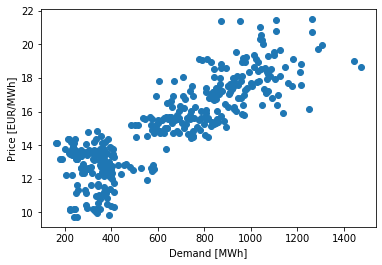

0.6351631966664049


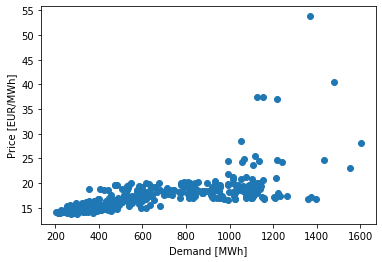

-0.14742209034134693


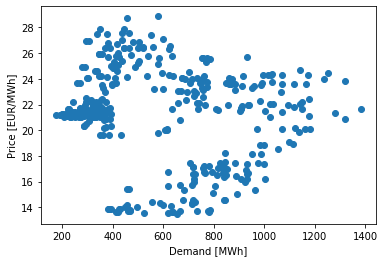

0.8477429120223461


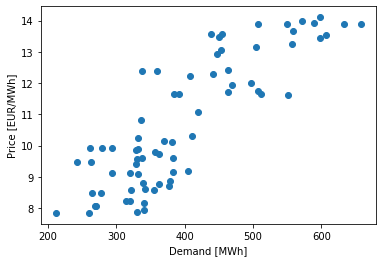

In [15]:
for i in range(2013,2020):
    print(np.corrcoef(final_results['Demand'].loc[str(i)+'-05-01':str(i+1)+'-04-30'],final_results['GPN'].loc[str(i)+'-05-01':str(i+1)+'-04-30'])[0,1])
    plt.scatter(final_results['Demand'].loc[str(i)+'-05-01':str(i+1)+'-04-30'], final_results['GPN'].loc[str(i)+'-05-01':str(i+1)+'-04-30'])
    plt.ylabel('Price [EUR/MWh]')
    plt.xlabel('Demand [MWh]')
    plt.show()